Import the libraries

In [ ]:
import os

import tensorflow as tf

import numpy as np
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [ ]:
# set the random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Load and inspect the dataset

In [ ]:
#read the dataset from csv file using pandas dataframe
#dataset = pd.read_csv("Training.csv")
dataset = pd.read_csv("/kaggle/input/memememe/Training.csv")
print(dataset.shape)
dataset.head()  #show first rows of the dataframe

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


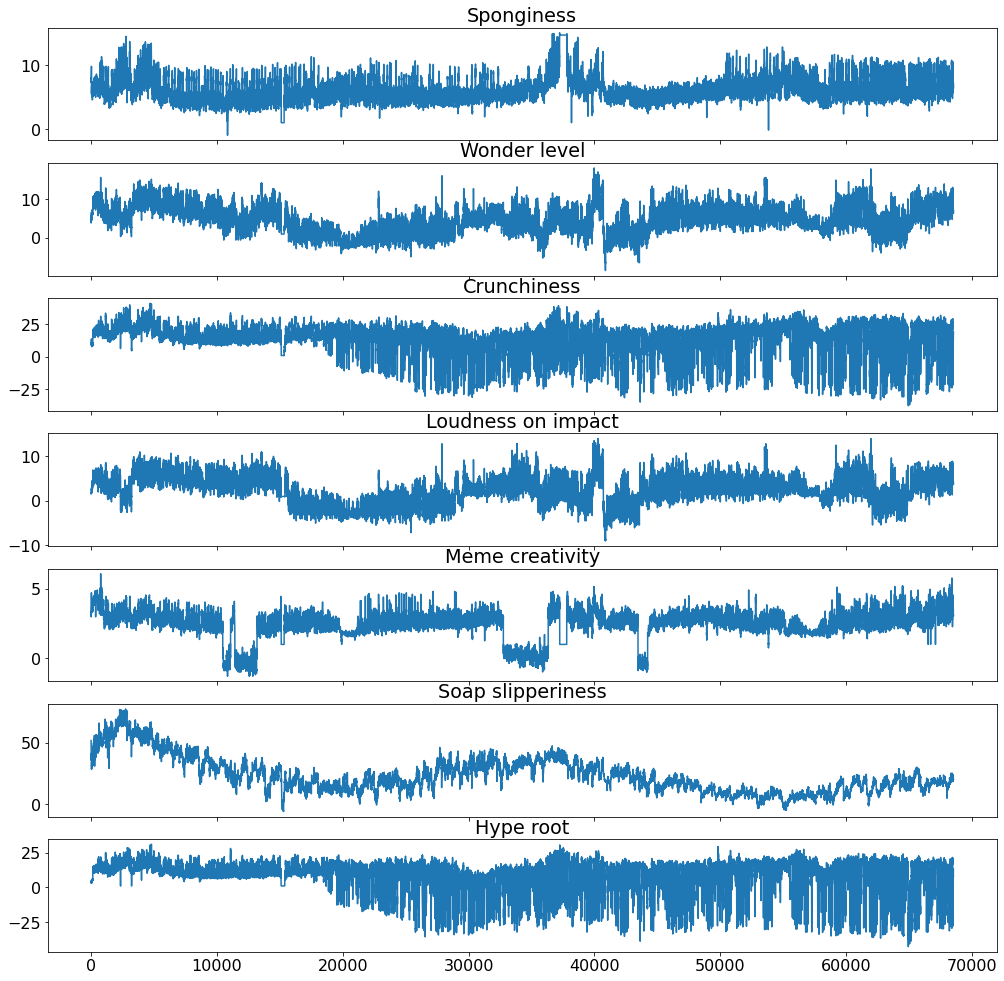

In [ ]:
#function to plot the dataset, dividing it in subplots, one for each feature
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

inspect_dataframe(dataset, dataset.columns)

Train/test split and normalization of the features

In [ ]:
split_percentage=0.1
#define how many test samples to use
test_size = int(dataset.shape[0]*split_percentage)


X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

print(X_train_raw.shape, X_test_raw.shape)

# Normalize features, on normalization use always just the training set, never testing set, normalize using training set
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min) #minMax scaler normalization of training samples
X_test_raw = (X_test_raw-X_min)/(X_max-X_min) #minMax scaler normalization of testing samples

(68528, 7) (6852, 7)


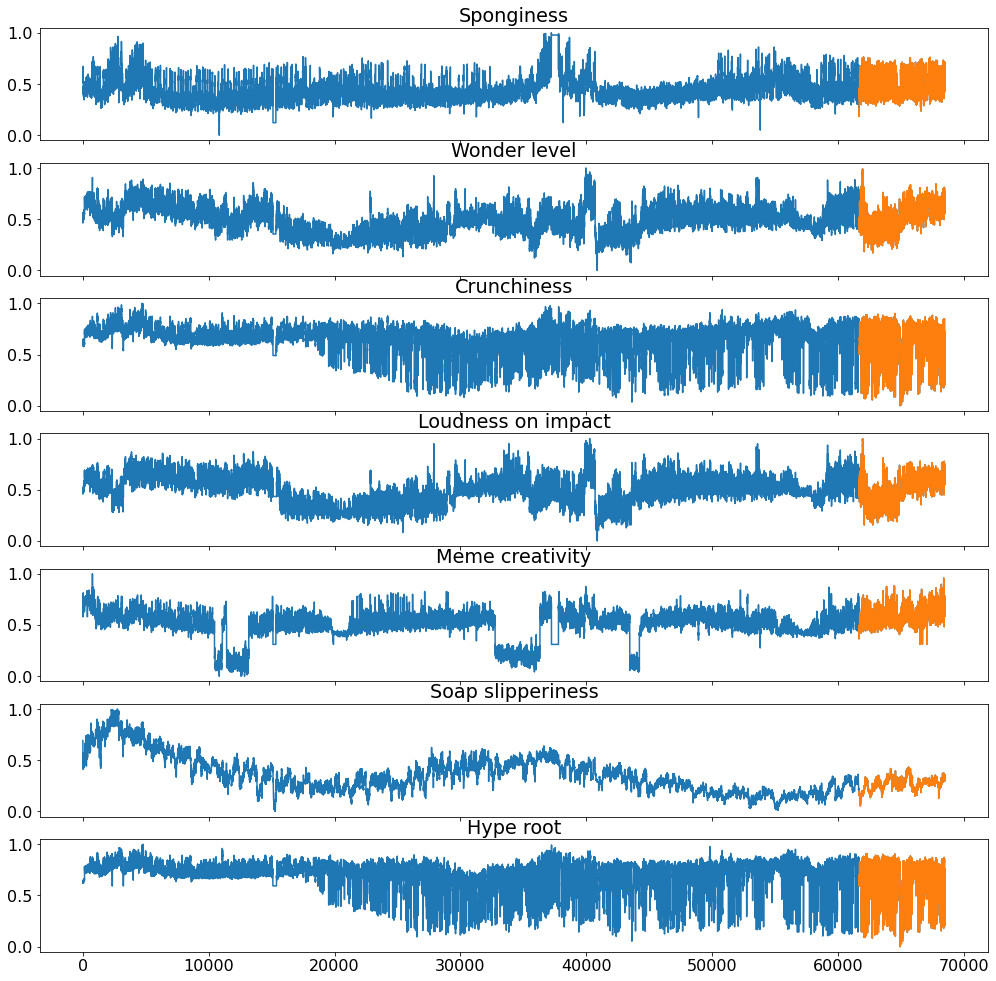

In [ ]:
#function to plot the normalized dataset together with the split in training and testing
def inspect_normalized_dataframe(train,test,columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(train[col],label='Train')
        axs[i].plot(test[col], label='Test')
        axs[i].set_title(col)
    plt.show()

inspect_normalized_dataframe(X_train_raw, X_test_raw, dataset.columns)


In [ ]:
window = 5000 #how many samples are considered each time
stride = 200 #how much to shift window at each iteration
telescope = 864 #how many samples to predict in the future
target_labels = dataset.columns #save the names of the columns

Function that creates the sequences to train the model

In [ ]:
#Collect subsequences to form the training set, take slice as input than select subsequent n values as target
#target are number of values we want to predict, start from 0 take 200 values, take subsequent 100 values for prediction that will be the target

def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0 #check that stride is sub-multiple of window size
    dataset = []
    labels = []
    
    temp_df = df.copy().values #create a dataframe containing the values extracted from variable passed df
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window  #check if padding is necessary wrt window size

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
#create traing and test sets, we want to predict all 7 features
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope) #pass training dataframe
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope) #pass testing dataframe
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((321, 5000, 7), (321, 864, 7), (21, 5000, 7), (21, 864, 7))

In [ ]:
#function to plot examples from the training set, one sample, that is 7 time series
#blue part is the 200 values that we give as input to network, orange part is the target to predict
#want to predict orange part for all the sensors
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

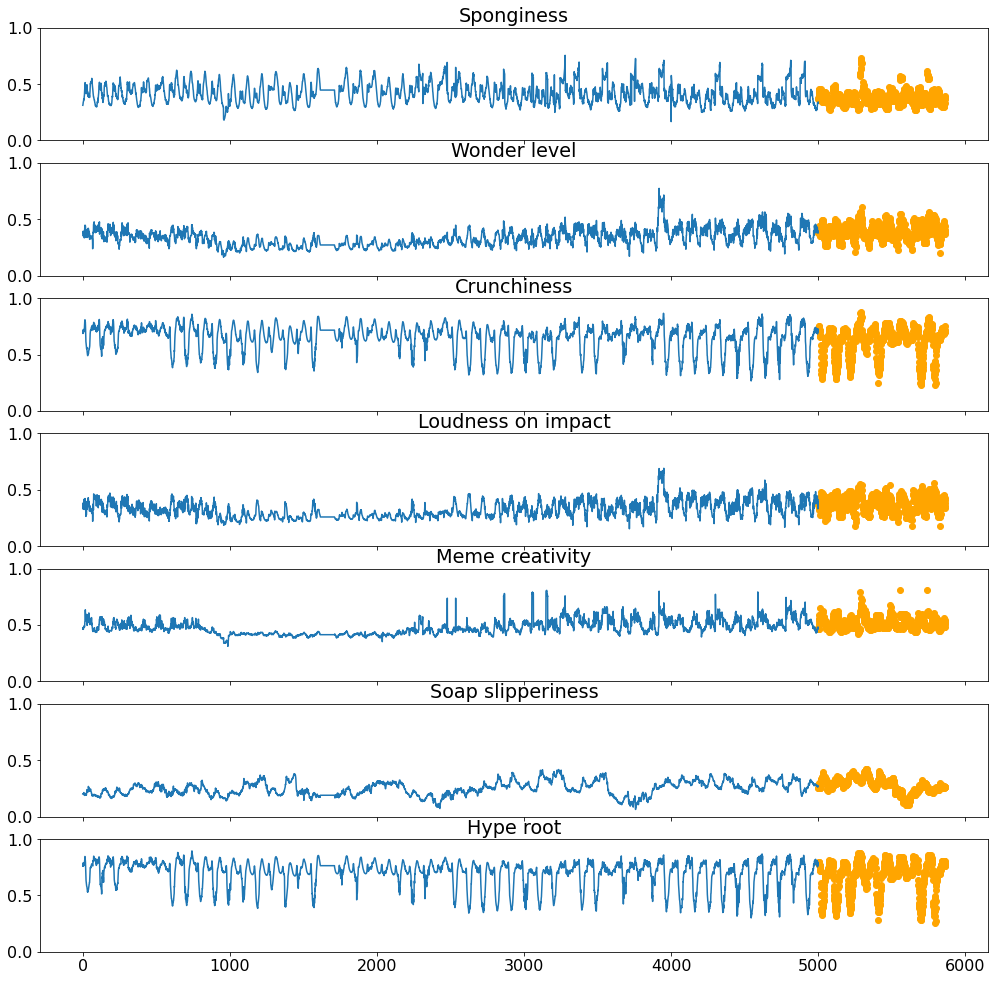

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
epochs = 1000
batch_size = 64
patience_epochs = epochs*0.2
patienceL = epochs*0.1


In [ ]:
def build_branch(i):
    conv=tfk.Sequential([
        tfkl.LSTM(60, return_sequences = True, kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.Dropout(.2, seed=seed),
        tfkl.LSTM(180, kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.Dropout(.2, seed=seed),
        tfkl.Dense(output_shape[0], kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.ELU(),
        tfkl.Reshape((output_shape[0],1))
        
    ],name="branch_"+str(i))
    return conv

def build_branch2(i):
    conv=tfk.Sequential([
        tfkl.LSTM(120, kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.Dropout(.2, seed=seed),
        tfkl.Dense(120, kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.ELU(),
        tfkl.Dense(240, kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.ELU(),
        tfkl.Dense(output_shape[0], kernel_initializer = tfk.initializers.GlorotUniform(seed)),
        tfkl.ELU(),
        tfkl.Reshape((output_shape[0],1))
        
    ],name="branch_"+str(i))
    return conv

#structure of the network, we can see the different input given to each branch and also the use of two different kind of branches
def build_model(input_shape,output_shape):
    
    inputs=[]
    branches=[]
    input_layer = tfkl.Input(shape=input_shape, name='Input_tot')
    
    inputs.append(tfkl.Input(shape=(input_shape[0],1),name="Input_"+str(0))) #sponginess
    branches.append(build_branch(0)(inputs[0])) 
    
    inputs.append(tfkl.Input(shape=(input_shape[0],1),name="Input_"+str(1))) #wonder
    branches.append(build_branch(1)(inputs[1])) 
    
    inputs.append(tfkl.Input(shape=(input_shape[0],1),name="Input_"+str(2))) #crunchiness CON DENSE
    branches.append(build_branch2(2)(inputs[2]))
    
    inputs.append(tfkl.Input(shape=(input_shape[0],1),name="Input_"+str(3))) #loudness
    branches.append(build_branch(3)(inputs[3])) 
    
    inputs.append(tfkl.Input(shape=(input_shape[0],1),name="Input_"+str(4))) #meme CON DENSE
    branches.append(build_branch2(4)(inputs[4]))
    
    inputs.append(input_layer)#sarebbe inputs[5]
    branches.append(build_branch2(5)(inputs[5]))                              #soap
    
    inputs.append(tfkl.Input(shape=(input_shape[0],1),name="Input_"+str(6))) #hype CON DENSE
    branches.append(build_branch2(6)(inputs[6]))
    
    #define losses for every output branch
    losses = {
            "branch_0": tfk.losses.MeanSquaredError(),
            "branch_1": tfk.losses.MeanSquaredError(),
            "branch_2": tfk.losses.MeanSquaredError(),
            "branch_3": tfk.losses.MeanSquaredError(),
            "branch_4": tfk.losses.MeanSquaredError(),
            "branch_5": tfk.losses.MeanSquaredError(),
            "branch_6": tfk.losses.MeanSquaredError()   

        }

    #define losses weights for every output branch
    losses_weights = {
            "branch_0": 1.0,
            "branch_1": 1.0,
            "branch_2": 1.0,
            "branch_3": 1.0,
            "branch_4": 1.0,
            "branch_5": 1.0,
            "branch_6": 1.0
    }

    model=tfk.Model(inputs=inputs,outputs=branches)
    model.compile(optimizer=tfk.optimizers.Adam(),loss=losses,loss_weights=losses_weights,metrics=["mae"])
        
    return model

2022-01-01 22:36:07.011733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-01 22:36:07.097424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-01 22:36:07.098122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-01 22:36:07.099195: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_0 (InputLayer)            [(None, 5000, 1)]    0                                            
__________________________________________________________________________________________________
Input_1 (InputLayer)            [(None, 5000, 1)]    0                                            
__________________________________________________________________________________________________
Input_2 (InputLayer)            [(None, 5000, 1)]    0                                            
__________________________________________________________________________________________________
Input_3 (InputLayer)            [(None, 5000, 1)]    0                                            
______________________________________________________________________________________________

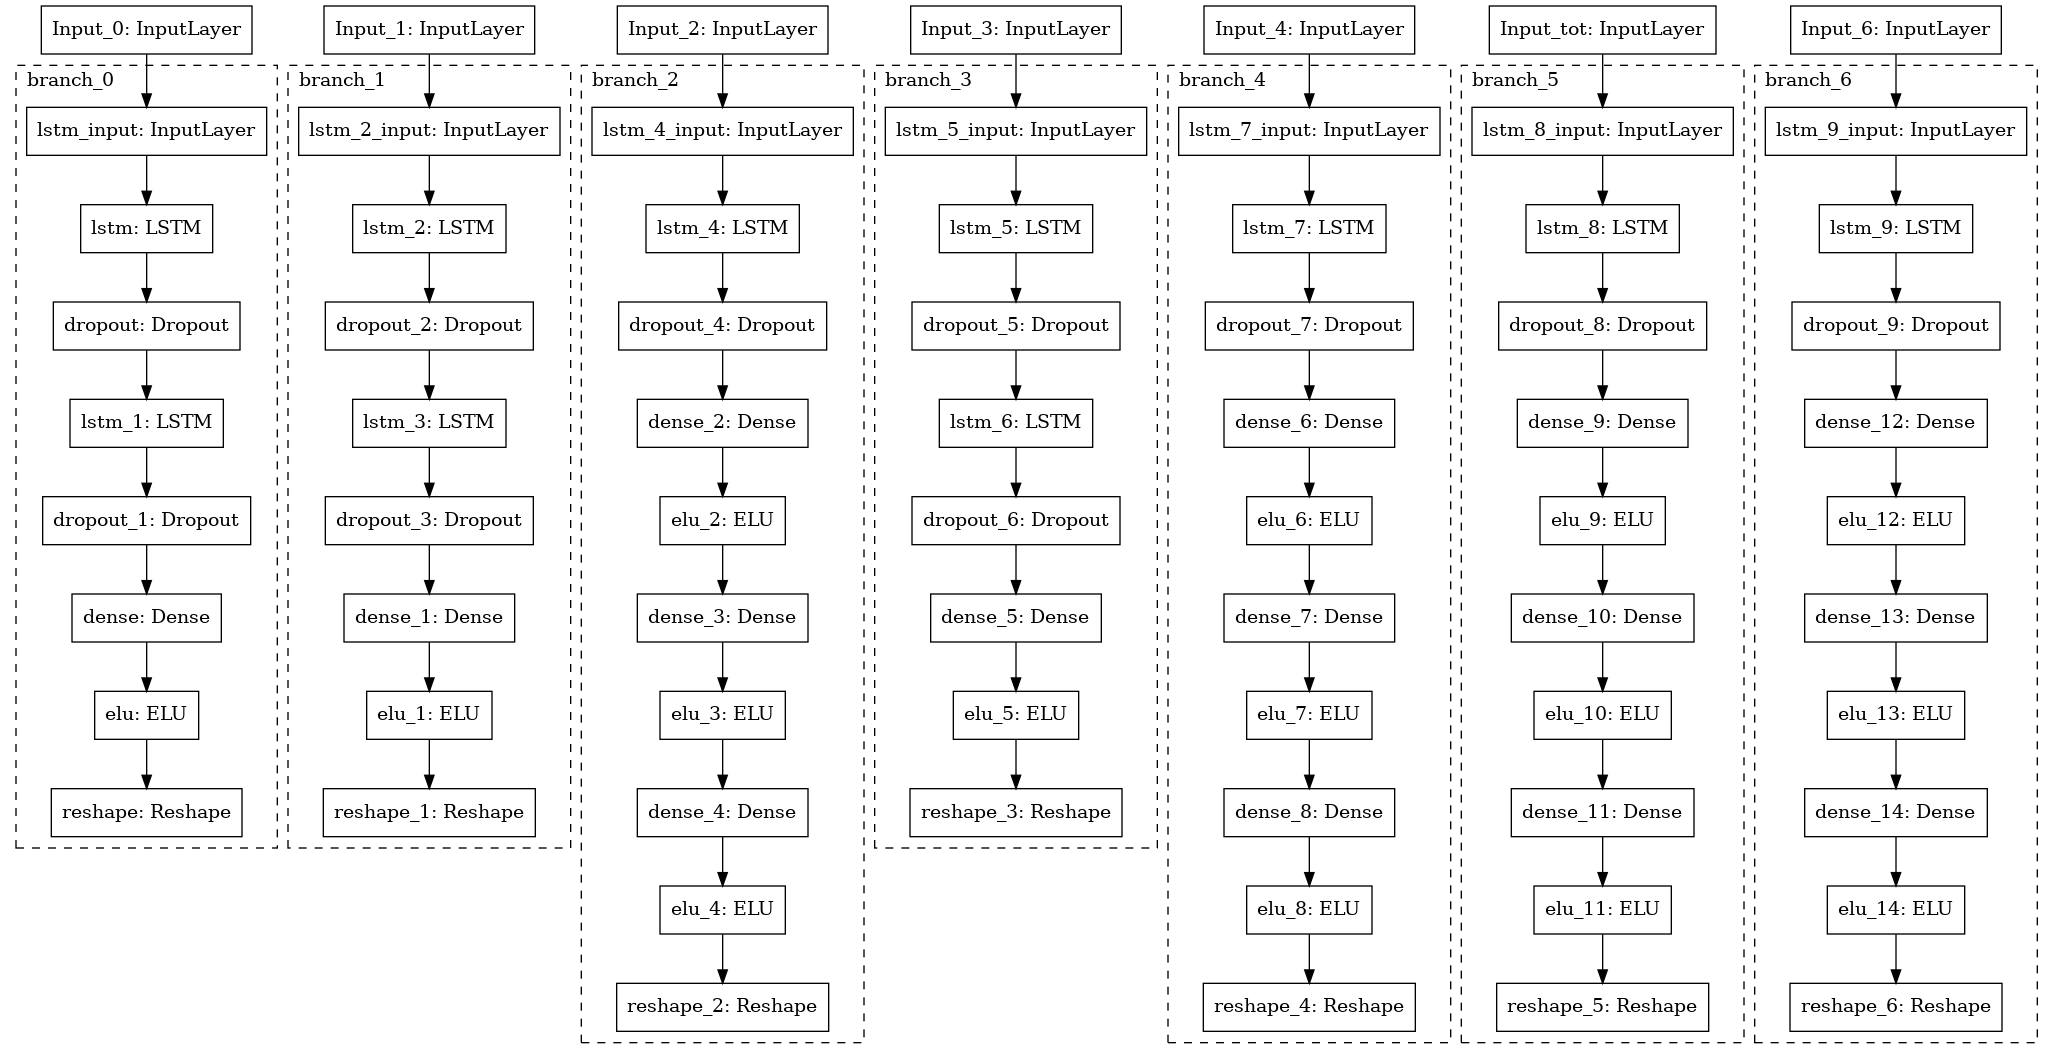

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

Training the model

In [ ]:
factor_RLR=0.5
min_LR=1e-5

In [ ]:
#training the model
print(X_train.shape)
print(y_train.shape)



#Dictionaries are used to pass the data
x_fit={
    "Input_0":X_train[:,:,0],
    "Input_1":X_train[:,:,1],
    "Input_2":X_train[:,:,2],
    "Input_3":X_train[:,:,3],
    "Input_4":X_train[:,:,4],
    "Input_tot":X_train[:,:,:],
    "Input_6":X_train[:,:,6]
}

y_fit={
    "branch_0": y_train[:,:,0],
    "branch_1": y_train[:,:,1],
    "branch_2": y_train[:,:,2],
    "branch_3": y_train[:,:,3],
    "branch_4": y_train[:,:,4],
    "branch_5": y_train[:,:,5],
    "branch_6": y_train[:,:,6]
}

history = model.fit(
    x = x_fit,
    y = y_fit,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,    #use 10% of values as validation set
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=patience_epochs, restore_best_weights=True), #early stopping and restore best weights
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=patienceL, factor=factor_RLR, min_lr=min_LR) #decrease learing rate 
    ]
).history


(321, 5000, 7)
(321, 864, 7)


2022-01-01 22:36:15.105919: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000


2022-01-01 22:36:27.978409: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5/5 [==============================] - 29s 3s/step - loss: 1.8882 - branch_0_loss: 0.1886 - branch_1_loss: 0.2375 - branch_2_loss: 0.4077 - branch_3_loss: 0.2439 - branch_4_loss: 0.2357 - branch_5_loss: 0.1137 - branch_6_loss: 0.4610 - branch_0_mae: 0.4170 - branch_1_mae: 0.4704 - branch_2_mae: 0.6213 - branch_3_mae: 0.4752 - branch_4_mae: 0.4652 - branch_5_mae: 0.2991 - branch_6_mae: 0.6610 - val_loss: 1.3822 - val_branch_0_loss: 0.1615 - val_branch_1_loss: 0.2009 - val_branch_2_loss: 0.2990 - val_branch_3_loss: 0.1645 - val_branch_4_loss: 0.2318 - val_branch_5_loss: 0.0246 - val_branch_6_loss: 0.2999 - val_branch_0_mae: 0.3773 - val_branch_1_mae: 0.4252 - val_branch_2_mae: 0.5081 - val_branch_3_mae: 0.3752 - val_branch_4_mae: 0.4716 - val_branch_5_mae: 0.1277 - val_branch_6_mae: 0.5075
Epoch 2/1000
5/5 [==============================] - 12s 2s/step - loss: 0.8297 - branch_0_loss: 0.0871 - branch_1_loss: 0.1082 - branch_2_loss: 0.1914 - branch_3_loss: 0.1065 - branch_4_loss: 0.1035 - 

Plot errors and learning rate

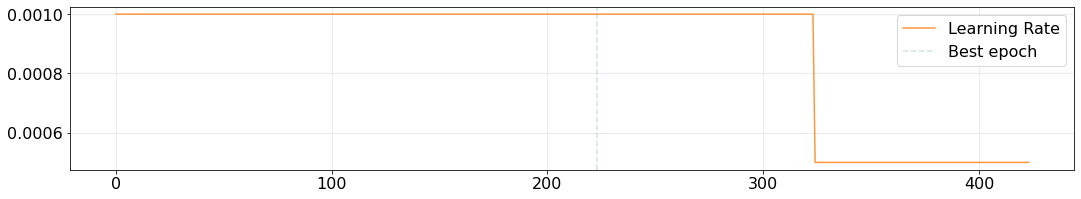

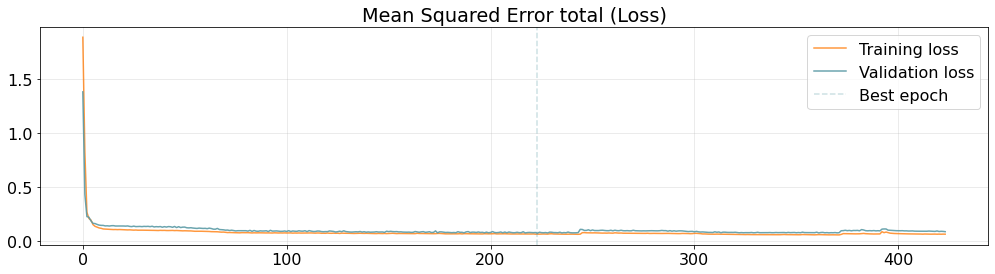

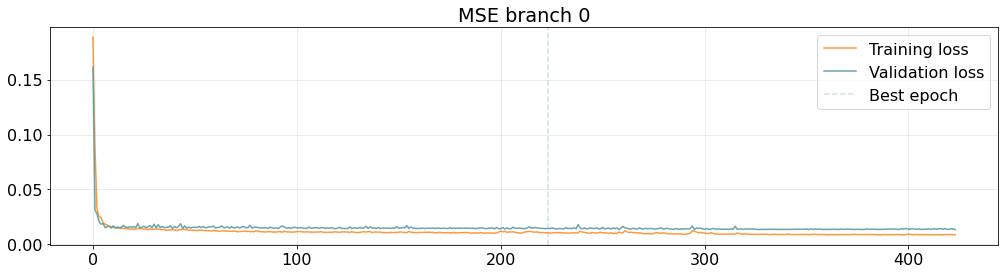

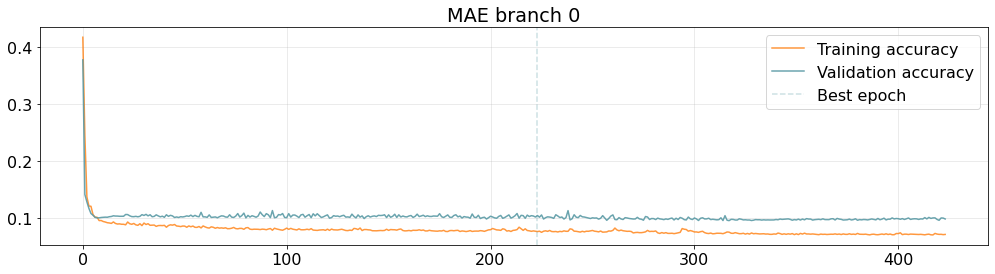

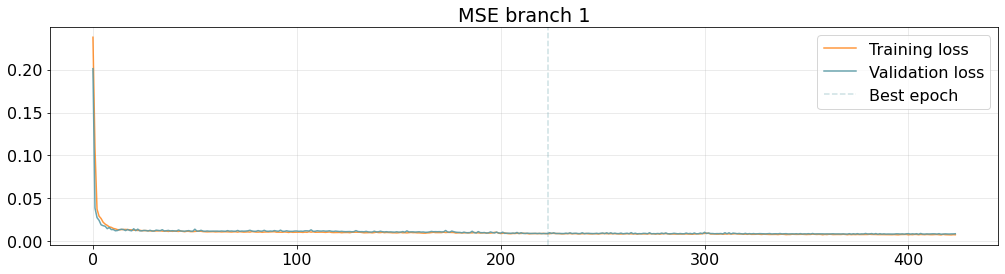

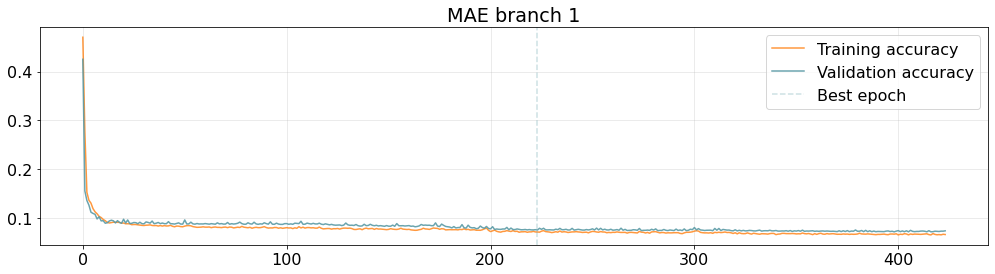

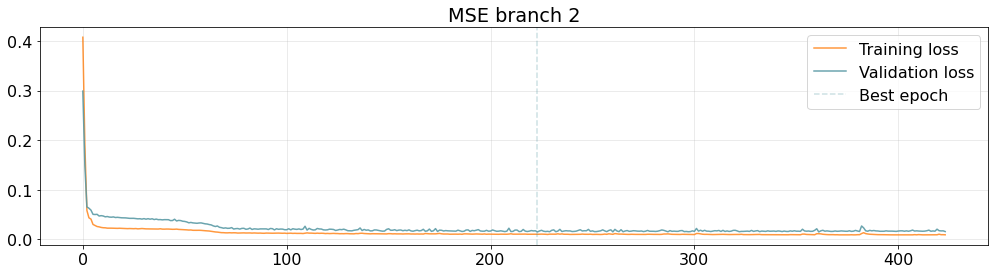

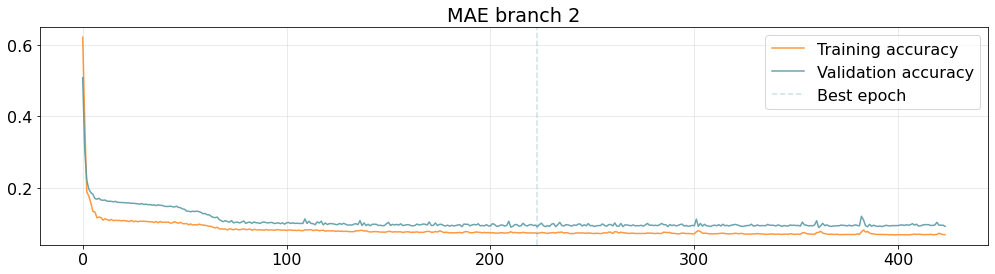

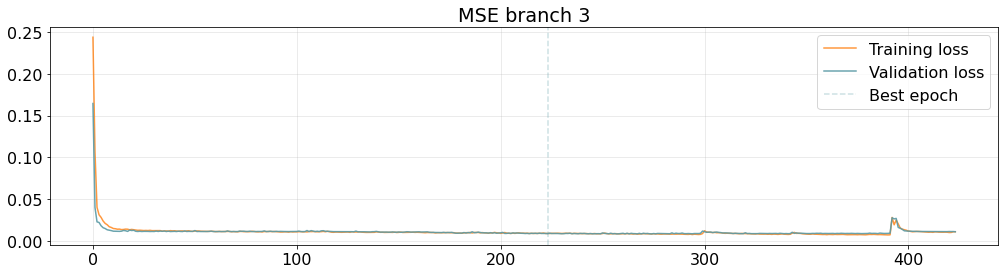

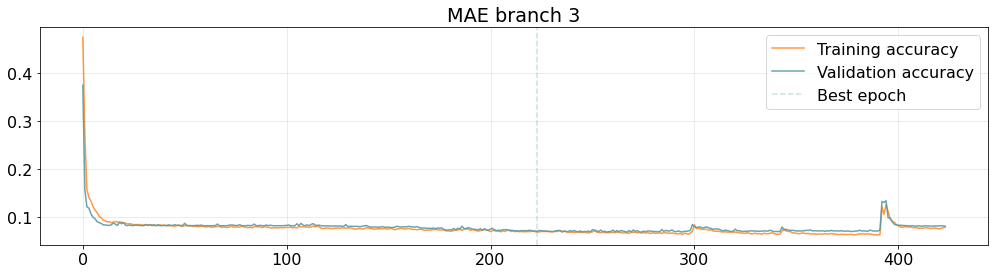

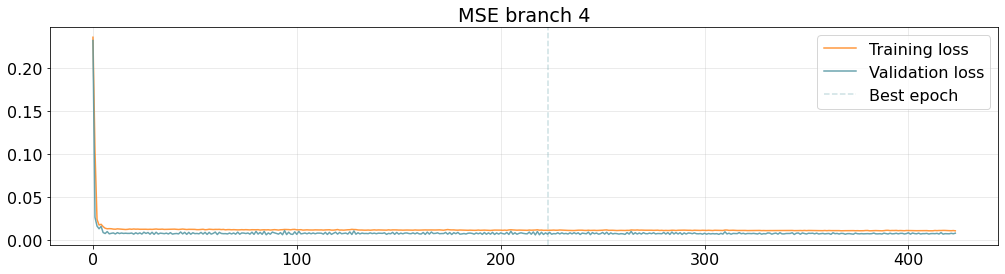

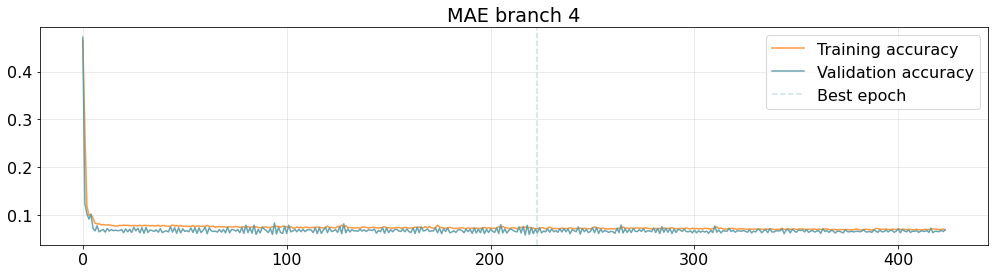

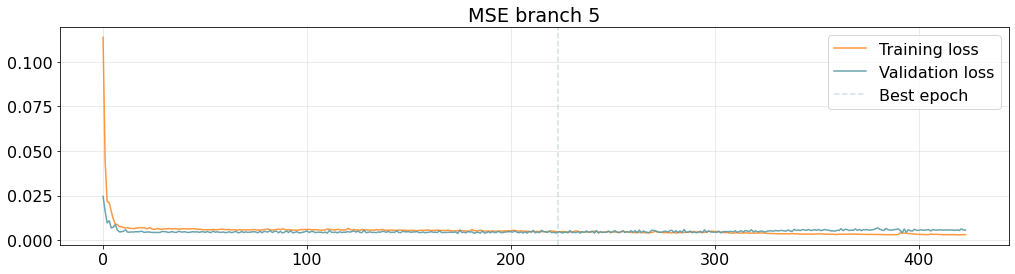

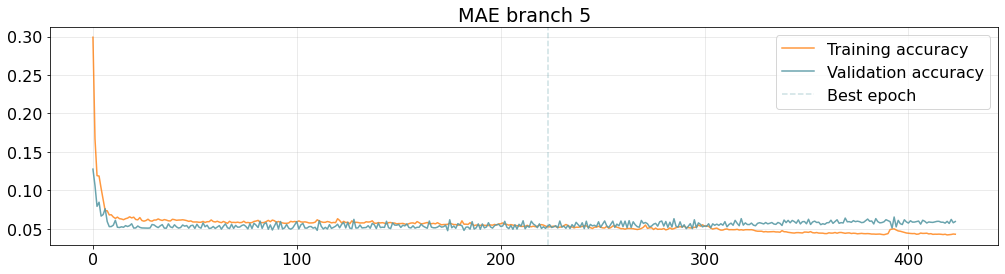

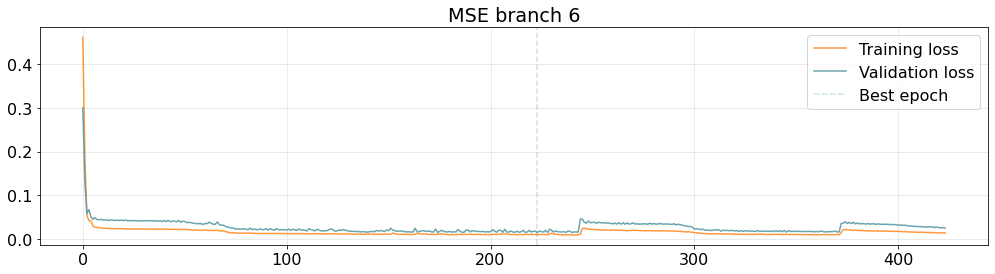

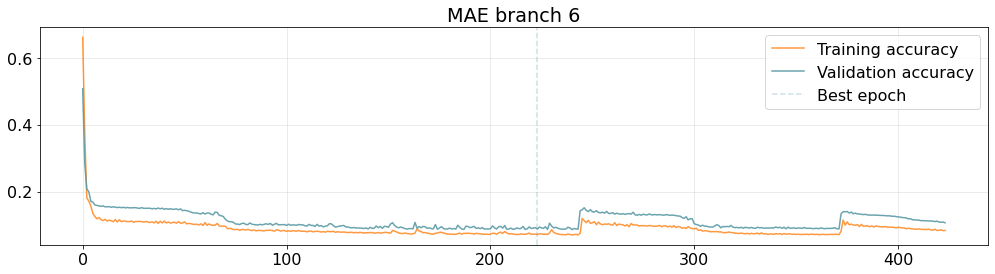

In [ ]:
def plot_MSE_MAE_LR(history,shape):

    #define as best epoch the one minimizing validation loss
    best_epoch = np.argmin(history['val_loss'])
    
    #Plot the effect of callback that decreases the learining rate
    plt.figure(figsize=(18,3))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()
    
    #plot MSE of training and validation
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Squared Error total (Loss)')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()
    
    for i in range(shape):
    
        plt.figure(figsize=(17,4))
        plt.plot(history['branch_'+str(i)+'_loss'], label='Training loss', alpha=.8, color='#ff7f0e')
        plt.plot(history['val_'+'branch_'+str(i)+'_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
        plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
        plt.title('MSE branch '+str(i))
        plt.legend()
        plt.grid(alpha=.3)
        plt.show()

        #plot MAE of training and validation
        plt.figure(figsize=(17,4))
        plt.plot(history['branch_'+str(i)+'_mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
        plt.plot(history['val_'+'branch_'+str(i)+'_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
        plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
        plt.title('MAE branch '+str(i))
        plt.legend()
        plt.grid(alpha=.3)
        plt.show()

    

plot_MSE_MAE_LR(history,output_shape[-1])

Save the model

In [ ]:
model.save('DirectForecasting')
#model = tfk.models.load_model('/kaggle/input/submodel1/DirectForecasting')

2022-01-02 00:02:12.690862: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Predicting Test set

In [ ]:
#function to show one example of prediction in a sequence (taken from the test set)
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
# Predict the test set 
x_predict={
    "Input_0":X_test[:,:,0],
    "Input_1":X_test[:,:,1],
    "Input_2":X_test[:,:,2],
    "Input_3":X_test[:,:,3],
    "Input_4":X_test[:,:,4],
    "Input_tot":X_test[:,:,:],
    "Input_6":X_test[:,:,6]
    
}

predictions = model.predict(x_predict)
print(predictions[0].shape)

predictions=np.array(predictions)
predictions=np.swapaxes(predictions,0,3)[0]
print(predictions.shape)


mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(21, 864, 1)
(21, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.009543427>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07552275>)

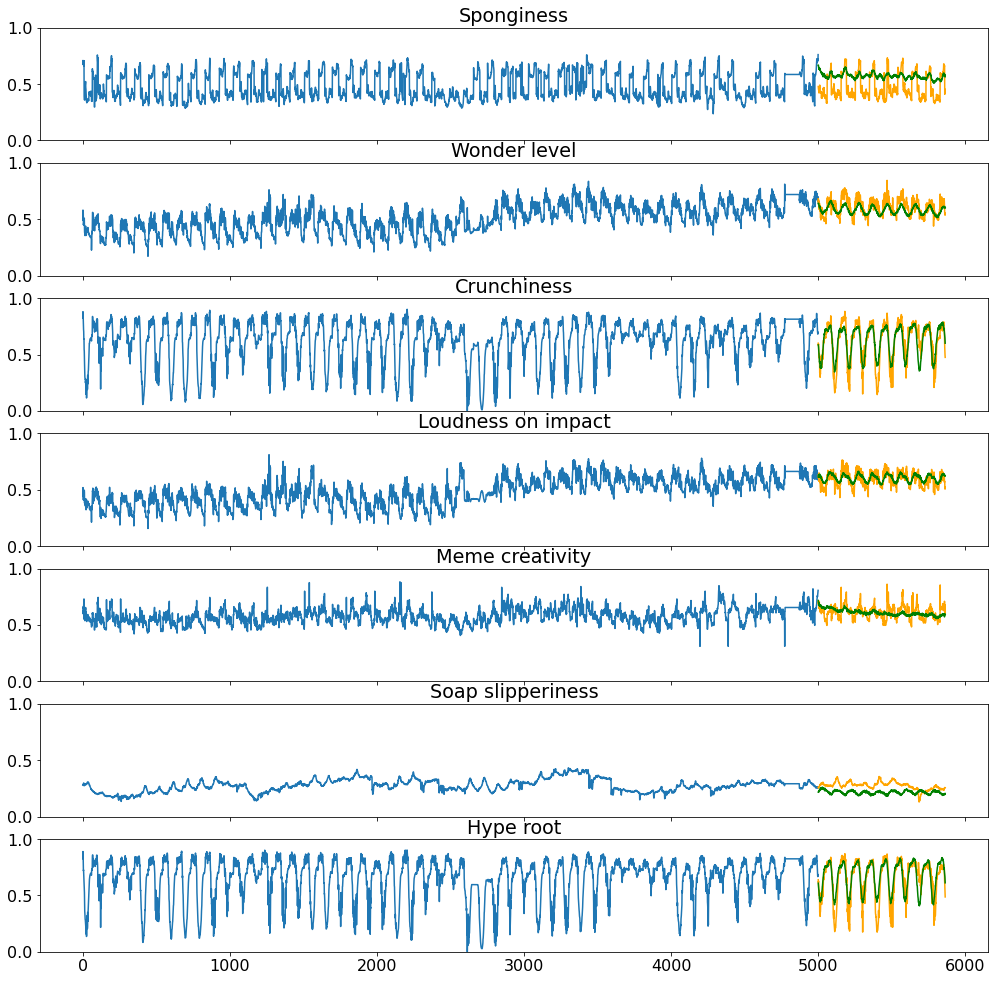

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

Predict the future of the time series

In [ ]:
#future is the very last window that we will use to predict outside the dataset, We won't have target for that prediction
future = dataset[-window:]  #take the last 200 instances of the dataset
future = (future-X_min)/(X_max-X_min) #normalize the values using again the training set
future = np.expand_dims(future, axis=0) #add 1 as first dimension
future.shape #print the shape of future

(1, 5000, 7)

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
#[future[:,:,0],future[:,:,1],future[:,:,2],future[:,:,3],future[:,:,4],future[:,:,5],future[:,:,6]]
future_fit={
    "Input_0":future[:,:,0],
    "Input_1":future[:,:,1],
    "Input_2":future[:,:,2],
    "Input_3":future[:,:,3],
    "Input_4":future[:,:,4],
    "Input_tot":future[:,:,:],
    "Input_6":future[:,:,6]
}
future_predictions = model.predict(future_fit)
future_predictions=np.array(future_predictions)
future_predictions=np.swapaxes(future_predictions,0,3)[0]

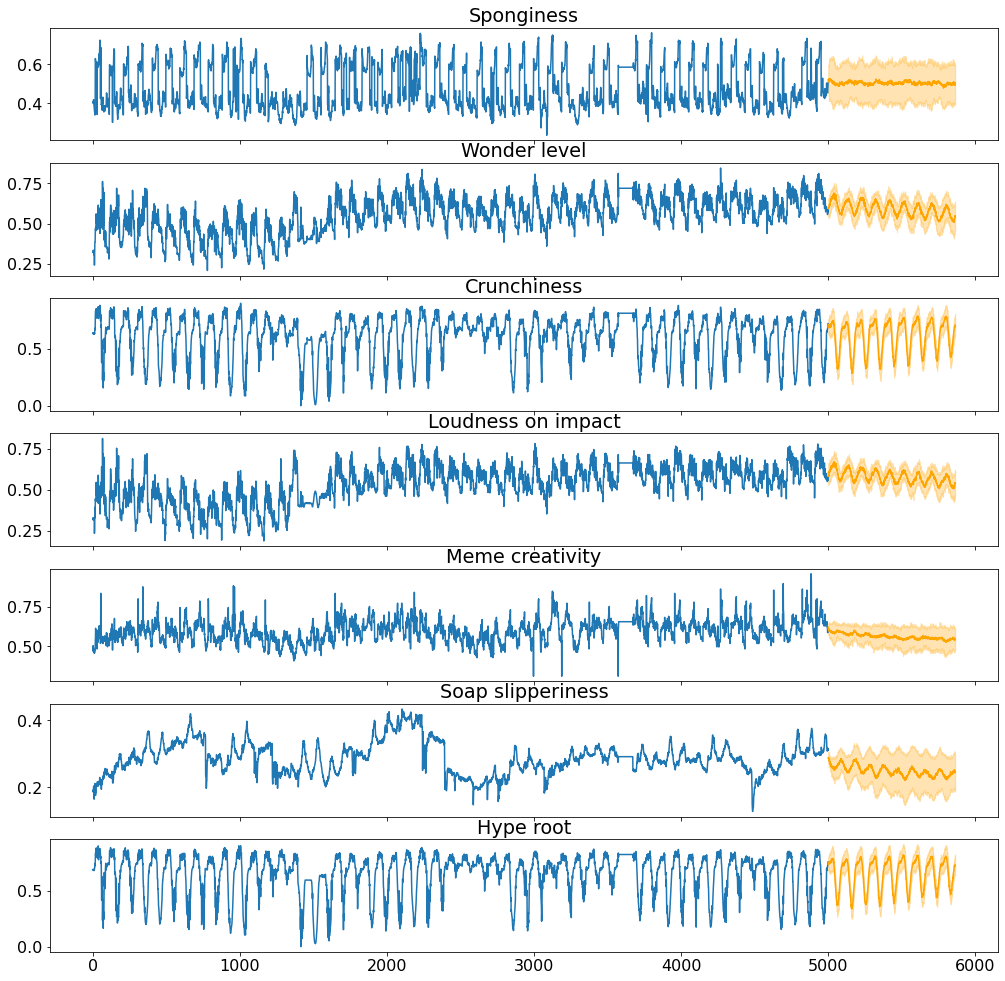

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()